### Goal : Plot MAPE*nb_features

Conditions :

- feature_importance from random forest
- 90% training, 10% test
- best hyper-parameters

--

#### Imports

In [1]:
import tuxml
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
features = tuxml.load_dataset()

# normalization of the nb yes/no/module counters
col = features.columns
# I assumed 12611 was (around) the number of real options we can change to compile the linux kernel => cf option_columns.json
nb_features = 12611
to_normalize = ['nbyes', 'nbno', 'nbmodule', 'nbyesmodule']
for feat in to_normalize:
    if feat in col:
        features[feat] = features[feat]/nb_features

df_selection = pd.read_csv('feature_importanceRF.csv', names = ['features', 'imp'], skiprows = 0)
selection = df_selection['features']
imp = df_selection['imp']
sorted_imp = sorted(imp, reverse = True)

def choose_features(nb_features):
    
    threshold_imp = sorted_imp[nb_features-1]

    final = selection[imp>threshold_imp]
    final[len(final)] = 'vmlinux'
    print(len(final))
    # selection
    features2 = features[final]
    
    return features2.replace([2,-1],0)

#### Test_functions


### Compute_features(p) gives the couple (MAPE train, MAPE test) returned  by the neural network fed with the p most important features (random forest)

In [3]:
def compute_standard(features):
    n = 65000
    sizes = np.array(features[0:n]['vmlinux'])
    x_train, x_test, y_train, y_test = train_test_split(features.drop('vmlinux', axis=1)[0:n], sizes, test_size = 0.1)

    nbCol = len(features.columns)

    x_train = np.array(x_train, dtype = np.float32)
    x_test =  np.array(x_test, dtype = np.float32)

    y_train = np.array(y_train, dtype = np.float32)
    y_test = np.array(y_test, dtype = np.float32)

    nb_features = x_train.shape[1]
    batch_size = 50
    nb_epochs = 30
    nb_batch_train = int(len(x_train)/batch_size)-1
    nb_batch_test = int(len(x_test)/batch_size)
    nb_node_layer1 = 200
    nb_node_layer2 = 300

    # slice the datasets => feed_dict was very slow, so I choose an iterator solution
    dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()

    with tf.device("/gpu:0"):
        # Layers training
        w_h1_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_features, nb_node_layer1)), name = "w_h1_tr")
        mat_h1_tr = tf.matmul(xtr, w_h1_tr)
        b_h1_tr = tf.Variable(tf.zeros(nb_node_layer1), name="b_h1_tr")
        out_h1_tr = tf.nn.relu(tf.add(mat_h1_tr, b_h1_tr))

        w_h2_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer1, nb_node_layer2)), name = "w_h2_tr")
        mat_h2_tr = tf.matmul(out_h1_tr, w_h2_tr)
        b_h2_tr = tf.Variable(tf.zeros(nb_node_layer2), name="b_h2_tr")
        out_h2_tr = tf.nn.relu(tf.add(mat_h2_tr, b_h2_tr))

        w_final_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer2, 1)), name = "w_final_tr")
        outputs_tr =  tf.reshape(tf.matmul(out_h2_tr, w_final_tr), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])

        # Layers test
        mat_h1_te = tf.matmul(xte, w_h1_tr)
        out_h1_te = tf.nn.relu(tf.add(mat_h1_te, b_h1_tr))

        mat_h2_te = tf.matmul(out_h1_te, w_h2_tr)
        out_h2_te = tf.nn.relu(tf.add(mat_h2_te, b_h2_tr))

        outputs_te =  tf.reshape(tf.matmul(out_h2_te, w_final_tr), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])

        # Cost => MAPE
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        # Convergence function => AdamOptimizer
        train_step = tf.train.AdamOptimizer(learning_rate=0.5).minimize(train_cost)

        # train step with a lower learning rate => gain few % at the end
        tiny_train_step = tf.train.AdamOptimizer(learning_rate=0.025).minimize(train_cost)

        # allocate memory for tensors
        init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for j in range(nb_epochs):
            if j < 20:
                sess.run(iterator_train.initializer)
                for i in range(nb_batch_train):
                    val = sess.run(train_step)
                #print("Cout entrainement epoch n°", j+1, ":",  sess.run(train_cost))
            else:
                sess.run(iterator_train.initializer)
                for i in range(nb_batch_train):
                    val = sess.run(tiny_train_step)
                #print("Cout entrainement epoch n°", j+1, ":",  sess.run(train_cost))
        sess.run(iterator_train.initializer)
        mape = 0
        for i in range(nb_batch_train):
            mape+=sess.run(train_cost)
        mape_train = mape/nb_batch_train
        sess.run(iterator_test.initializer)
        mape = 0
        for i in range(nb_batch_test):
            mape+=sess.run(test_cost)
        mape_test = mape/nb_batch_test
        return (mape_train, mape_test)

### All the features are not supported (it creates a tensor bigger than 2 Gigabytes, and crashes the kernel), but by reducing the number of the first layer to 200 nodes, we can compute until 8000 features.

In [4]:
len(df_selection)

9239

Results

In [5]:
nb_features = [50,100,250,500,750,1000,1200,1500,2000,2500,3000,4000,5000,6000,7000,8000, len(df_selection)]

res = dict()

for nb_f in nb_features:
    res[nb_f] = compute_standard(choose_features(nb_f))
    print(nb_f, res[nb_f])
res

50
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
50 (7.479199070926402, 7.966091020290668)
100
100 (6.362605203003635, 7.531402166073139)
250
250 (4.500358184246654, 6.166484997822688)
500
500 (3.87748114567113, 5.995050588020912)
750
750 (3.820579105610517, 6.031110539803138)
1000
1000 (3.723123487394217, 6.413761857839731)
1200
1200 (3.736771368592901, 6.631464187915508)
1500
1500 (4.0686002548583255, 7.396629575582651)
2000
2000 (4.167195938712415, 7.861370420455932)
2500
2500 (4.216191209208976, 7.952859753828783)
3000
3000 (4.419150530527146, 8.46539215674767)
4000
4000 (4.32036808150971, 8.760453568972075)
5000
5000 (4.253250440641588, 9.530968284606933)
6000
6000 (4.929930310457358, 9.787896585464477)
7000
7000 (4.68738895282468, 9.974623096906221)
8000
8000 (5.0598881624008065, 10.888339453477126)
8389
9239 (5.126091190848828, 10.496802975581243)


{50: (7.479199070926402, 7.966091020290668),
 100: (6.362605203003635, 7.531402166073139),
 250: (4.500358184246654, 6.166484997822688),
 500: (3.87748114567113, 5.995050588020912),
 750: (3.820579105610517, 6.031110539803138),
 1000: (3.723123487394217, 6.413761857839731),
 1200: (3.736771368592901, 6.631464187915508),
 1500: (4.0686002548583255, 7.396629575582651),
 2000: (4.167195938712415, 7.861370420455932),
 2500: (4.216191209208976, 7.952859753828783),
 3000: (4.419150530527146, 8.46539215674767),
 4000: (4.32036808150971, 8.760453568972075),
 5000: (4.253250440641588, 9.530968284606933),
 6000: (4.929930310457358, 9.787896585464477),
 7000: (4.68738895282468, 9.974623096906221),
 8000: (5.0598881624008065, 10.888339453477126),
 9239: (5.126091190848828, 10.496802975581243)}

In [7]:
res

{50: (7.479199070926402, 7.966091020290668),
 100: (6.362605203003635, 7.531402166073139),
 250: (4.500358184246654, 6.166484997822688),
 500: (3.87748114567113, 5.995050588020912),
 750: (3.820579105610517, 6.031110539803138),
 1000: (3.723123487394217, 6.413761857839731),
 1200: (3.736771368592901, 6.631464187915508),
 1500: (4.0686002548583255, 7.396629575582651),
 2000: (4.167195938712415, 7.861370420455932),
 2500: (4.216191209208976, 7.952859753828783),
 3000: (4.419150530527146, 8.46539215674767),
 4000: (4.32036808150971, 8.760453568972075),
 5000: (4.253250440641588, 9.530968284606933),
 6000: (4.929930310457358, 9.787896585464477),
 7000: (4.68738895282468, 9.974623096906221),
 8000: (5.0598881624008065, 10.888339453477126),
 9239: (5.126091190848828, 10.496802975581243)}

In [20]:
df = pd.DataFrame(np.transpose(pd.DataFrame(res)))
df.columns =["MAPE train", "MAPE test"]
ind_df = np.array(df.index)
# 8389 was the real number of features for the last launch
ind_df[len(ind_df)-1] = 8389
df.index = ind_df
df

,MAPE train,MAPE test
50,7.479199,7.966091
100,6.362605,7.531402
250,4.500358,6.166485
500,3.877481,5.995051
750,3.820579,6.031111
1000,3.723123,6.413762
1200,3.736771,6.631464
1500,4.068600,7.396630
2000,4.167196,7.861370
2500,4.216191,7.952860


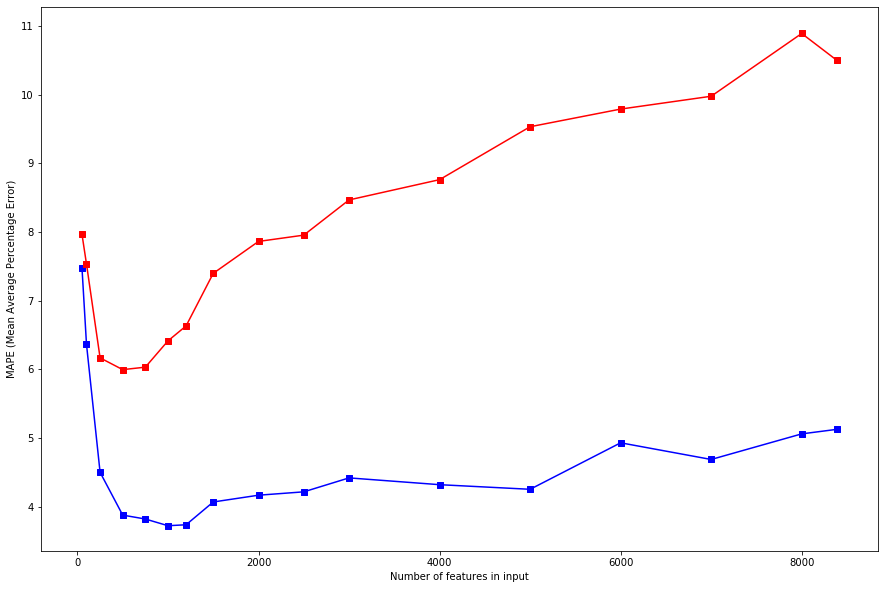

In [22]:
plt.figure(figsize =(15,10))
plt.scatter(ind_df, df["MAPE train"], color ="blue", marker = "s")
plt.plot(ind_df, df["MAPE train"], color ="blue")
plt.scatter(ind_df, df["MAPE test"], color ="red", marker = "s")
plt.plot(ind_df, df["MAPE test"], color ="red")
plt.xlabel("Number of features in input")
plt.ylabel("MAPE (Mean Average Percentage Error)")
plt.savefig("net_mape_nb_features.png")
plt.show()

train = blue,
test = red